In [1]:
# CATEGORY = "Baby_Products"
CATEGORY = "Video_Games"

# Define sequence lengths
MIN_SEQUENCE_LENGTH = 3
MAX_SEQUENCE_LENGTH = 100  # Adjust as needed

In [2]:
import sys
from pathlib import Path

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
sys.path.append(str(PROJECT_ROOT))

# Data directory
DATA_DIR = Path(PROJECT_ROOT, "data")
DATA_DIR.mkdir(exist_ok=True)

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import polars as pl

from src.logger import setup_logger

logger = setup_logger("dataprep")

## Load and merge data

In [4]:
# LOAD ORIGINAL METADATA
metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items.parquet"
item_df = pl.read_parquet(metadata_output_path)
logger.info(f"Loaded {len(item_df):,} items from {metadata_output_path}")

# LOAD AUGMENTED METADATA\
augmented_metadata_path = DATA_DIR / "output" / f"{CATEGORY}_metadata_extracted.parquet"
augmented_df = pl.read_parquet(augmented_metadata_path)
logger.info(f"Loaded {len(augmented_df):,} augmented metadata records from {augmented_metadata_path}")

# LOAD CLEANED DESCRIPTIONS
cleaned_descriptions_path = DATA_DIR / "output" / f"{CATEGORY}_descriptions_clean.csv"
cleaned_descriptions_df = pl.read_csv(cleaned_descriptions_path)
cleaned_descriptions_df = cleaned_descriptions_df.unique(subset=["parent_asin"])
cleaned_descriptions_df = cleaned_descriptions_df.filter(pl.col("clean_description") != "NA")
logger.info(f"Loaded {len(cleaned_descriptions_df):,} cleaned descriptions from {cleaned_descriptions_path}")

# LOAD CLEANED TITLES
cleaned_titles_path = DATA_DIR / "output" / f"{CATEGORY}_titles_clean.csv"
cleaned_titles_df = pl.read_csv(cleaned_titles_path)
cleaned_titles_df = cleaned_titles_df.unique(subset=["parent_asin"])
cleaned_titles_df = cleaned_titles_df.filter(pl.col("clean_title") != "NA")
logger.info(f"Loaded {len(cleaned_titles_df):,} cleaned titles from {cleaned_titles_path}")

# MERGE DATAFRAMES
item_df = item_df.join(cleaned_descriptions_df, on="parent_asin", how="inner")
item_df = item_df.join(cleaned_titles_df, on="parent_asin", how="inner")
item_df = item_df.join(augmented_df, on="parent_asin", how="left")  # Left join to keep all items
logger.info(f"Merged {len(item_df):,} items with cleaned descriptions, titles, and augmented metadata")

21:05:27 - Loaded 465 items from /Users/amirmasoud/personal/v_tests/semantic-ids-llm/data/output/Video_Games_items.parquet
21:05:27 - Loaded 465 augmented metadata records from /Users/amirmasoud/personal/v_tests/semantic-ids-llm/data/output/Video_Games_metadata_extracted.parquet
21:05:27 - Loaded 465 cleaned descriptions from /Users/amirmasoud/personal/v_tests/semantic-ids-llm/data/output/Video_Games_descriptions_clean.csv
21:05:27 - Loaded 465 cleaned titles from /Users/amirmasoud/personal/v_tests/semantic-ids-llm/data/output/Video_Games_titles_clean.csv
21:05:27 - Merged 465 items with cleaned descriptions, titles, and augmented metadata


In [5]:
# Clean up xml tags that remain
item_df = item_df.with_columns(
    pl.col("clean_description")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_description"),
    pl.col("clean_title")
    .str.replace_all(r"</?[^>]+>", " ")  # Remove all tags
    .str.replace_all(r"\s+", " ")  # Collapse multiple spaces
    .str.strip_chars()  # Trim whitespace
    .alias("clean_title"),
)

assert (
    len(
        item_df.filter(pl.col("clean_description").str.contains("clean_description")).select(
            ["description_text", "clean_description"]
        )
    )
    == 0
)
assert len(item_df.filter(pl.col("clean_title").str.contains("clean_title")).select(["title", "clean_title"])) == 0

## Description Length Analysis

In [6]:
# Calculate character lengths for original and cleaned descriptions
item_df = item_df.with_columns(
    [
        pl.col("description_text").str.len_chars().cast(pl.Int64).alias("original_desc_length"),
        pl.col("clean_description").str.len_chars().cast(pl.Int64).alias("clean_desc_length"),
        pl.col("title").str.len_chars().cast(pl.Int64).alias("original_title_length"),
        pl.col("clean_title").str.len_chars().cast(pl.Int64).alias("clean_title_length"),
    ]
)

item_df = item_df.with_columns(
    [
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).cast(pl.Int64).alias("desc_char_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length"))
        .cast(pl.Float64)
        .alias("desc_reduction_prop"),
        (pl.col("original_title_length") - pl.col("clean_title_length")).cast(pl.Int64).alias("title_char_reduction"),
        ((pl.col("original_title_length") - pl.col("clean_title_length")) / pl.col("original_title_length"))
        .cast(pl.Float64)
        .alias("title_reduction_prop"),
    ]
)

# Calculate statistics
stats = item_df.select(
    [
        pl.col("original_desc_length").mean().alias("original_desc_mean"),
        pl.col("original_desc_length").median().alias("original_desc_median"),
        pl.col("original_desc_length").std().alias("original_desc_std"),
        pl.col("clean_desc_length").mean().alias("clean_desc_mean"),
        pl.col("clean_desc_length").median().alias("clean_desc_median"),
        pl.col("clean_desc_length").std().alias("clean_desc_std"),
        (pl.col("original_desc_length") - pl.col("clean_desc_length")).mean().alias("avg_desc_reduction"),
        ((pl.col("original_desc_length") - pl.col("clean_desc_length")) / pl.col("original_desc_length") * 100)
        .mean()
        .alias("avg_desc_reduction_pct"),
    ]
)

logger.info("Description Length Statistics:")
logger.info("=" * 50)
for col in stats.columns:
    value = stats[col][0]
    if "pct" in col:
        logger.info(f"{col}: {value:.1f}%")
    else:
        logger.info(f"{col}: {value:.1f}")

# Calculate reduction statistics
total_original_chars = item_df["original_desc_length"].sum()
total_clean_chars = item_df["clean_desc_length"].sum()
total_reduction = total_original_chars - total_clean_chars
total_reduction_pct = (total_reduction / total_original_chars) * 100

logger.info("Total Character Statistics:")
logger.info("=" * 50)
logger.info(f"Total original characters: {total_original_chars:,}")
logger.info(f"Total clean characters: {total_clean_chars:,}")
logger.info(f"Total reduction: {total_reduction:,} ({total_reduction_pct:.1f}%)")

21:05:30 - Description Length Statistics:
21:05:30 - ==================================================
21:05:30 - original_desc_mean: 1130.4
21:05:30 - original_desc_median: 653.0
21:05:30 - original_desc_std: 1395.2
21:05:30 - clean_desc_mean: 593.4
21:05:30 - clean_desc_median: 554.0
21:05:30 - clean_desc_std: 272.1
21:05:30 - avg_desc_reduction: 537.0
21:05:30 - avg_desc_reduction_pct: 14.6%
21:05:30 - Total Character Statistics:
21:05:30 - ==================================================
21:05:30 - Total original characters: 525,643
21:05:30 - Total clean characters: 275,919
21:05:30 - Total reduction: 249,724 (47.5%)


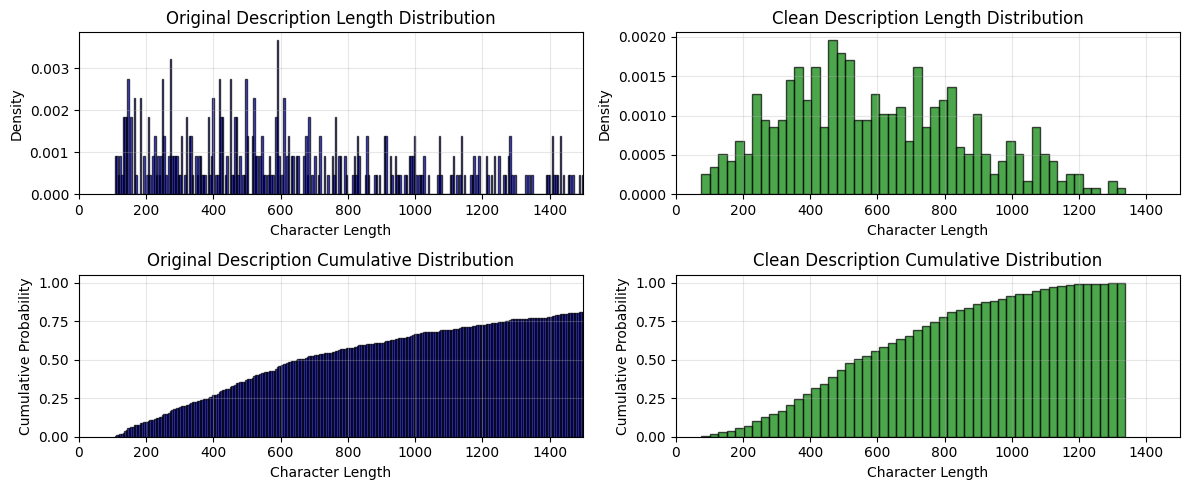

In [7]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 1500

# Convert to numpy arrays for plotting
original_lengths = item_df["original_desc_length"].to_numpy()
clean_lengths = item_df["clean_desc_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=2000, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Description Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Description Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=2000, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Description Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Description Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

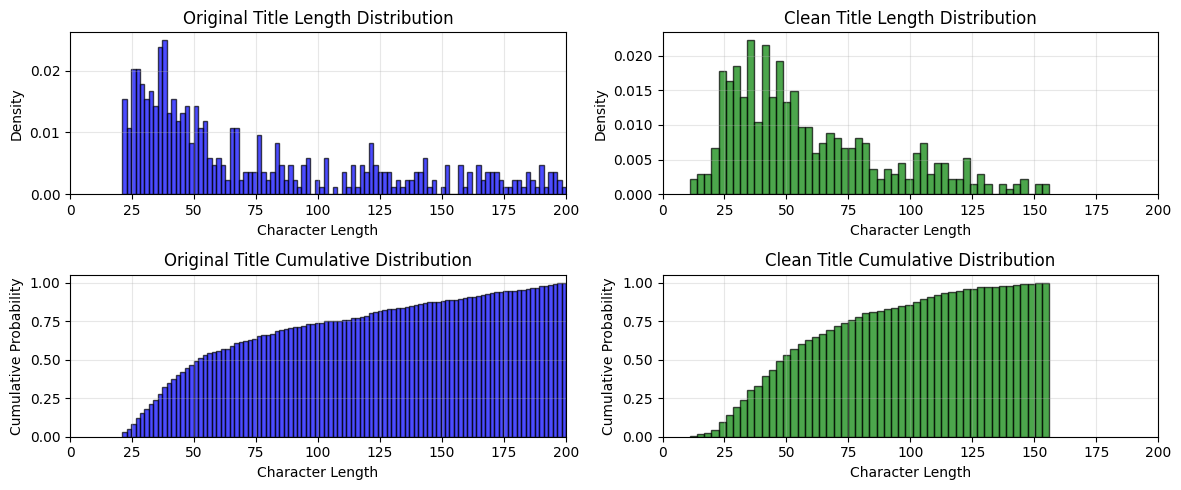

In [8]:
# Create figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(12, 5))
X_AXIS_LIMIT = 200

# Convert to numpy arrays for plotting
original_lengths = item_df["original_title_length"].to_numpy()
clean_lengths = item_df["clean_title_length"].to_numpy()

# 1. Histogram with density for original descriptions
ax1 = axes[0, 0]
n1, bins1, patches1 = ax1.hist(original_lengths, bins=100, density=True, alpha=0.7, color="blue", edgecolor="black")
ax1.set_xlabel("Character Length")
ax1.set_ylabel("Density")
ax1.set_title("Original Title Length Distribution")
ax1.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax1.grid(True, alpha=0.3)

# 2. Histogram with density for clean descriptions
ax2 = axes[0, 1]
n2, bins2, patches2 = ax2.hist(clean_lengths, bins=50, density=True, alpha=0.7, color="green", edgecolor="black")
ax2.set_xlabel("Character Length")
ax2.set_ylabel("Density")
ax2.set_title("Clean Title Length Distribution")
ax2.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility
ax2.grid(True, alpha=0.3)

# 3. Cumulative distribution for original descriptions
ax3 = axes[1, 0]
sorted_original = np.sort(original_lengths)
cumulative_original = np.arange(1, len(sorted_original) + 1) / len(sorted_original)
ax3.hist(sorted_original, bins=100, cumulative=True, density=True, alpha=0.7, color="blue", edgecolor="black")
ax3.set_xlabel("Character Length")
ax3.set_ylabel("Cumulative Probability")
ax3.set_title("Original Title Cumulative Distribution")
ax3.grid(True, alpha=0.3)
ax3.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

# 4. Cumulative distribution for clean descriptions
ax4 = axes[1, 1]
sorted_clean = np.sort(clean_lengths)
cumulative_clean = np.arange(1, len(sorted_clean) + 1) / len(sorted_clean)
ax4.hist(sorted_clean, bins=50, cumulative=True, density=True, alpha=0.7, color="green", edgecolor="black")
ax4.set_xlabel("Character Length")
ax4.set_ylabel("Cumulative Probability")
ax4.set_title("Clean Title Cumulative Distribution")
ax4.grid(True, alpha=0.3)
ax4.set_xlim(0, X_AXIS_LIMIT)  # Limit x-axis to 99th percentile for better visibility

plt.tight_layout()
plt.show()

In [9]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_desc_length") < 200)
    .sort("desc_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "title",
            "original_desc_length",
            "clean_desc_length",
            "desc_char_reduction",
            "desc_reduction_prop",
            "description_text",
            "clean_description",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["description_text", "clean_description", "original_desc_length", "clean_desc_length", "desc_reduction_prop"]
).head(5)

21:07:55 - Short clean sample: 25


description_text,clean_description,original_desc_length,clean_desc_length,desc_reduction_prop
str,str,i64,i64,f64
"""System Requirements: Supported Platforms: PlayStation 4 Supported Platforms: PlayStation 4 PlayStation account required for game activation and installation""","""PlayStation 4. A PlayStation account is required for game activation and installation.""",156,86,0.448718
"""Color: Grey. Brand New, High Quality.Material: Silicone.Package Includes: 10 pcs Joystick Caps .You will get what you see in the picture.""","""This package includes 10 grey joystick caps made from high-quality silicone.""",137,76,0.445255
"""These thumbsticks are a direct replacement to your original Xbox 360 controller thumbsticks. Whether you are replacing worn out thumbsticks or simply getting these to spruce up the look of your controller, you will not be disappointed! Installation requires disassembling your controller.""","""Direct replacement Xbox 360 controller thumbsticks, perfect for replacing worn-out parts or refreshing your controller's appearance. Installation requires controller disassembly.""",288,178,0.381944
"""Instantly transform your plain and boring Xbox One console into a super cool piece of art with the application of one of our stick-on Xbox decals!""","""Instantly transform your plain Xbox One console into a stylish piece of art with our easy-to-apply decals.""",146,106,0.273973
"""Please don't hesitate to contact us if you have any questions or concerns before or after your purchase. We are committed to your 100% satisfaction.""","""We are committed to your 100% satisfaction. Please contact us with any questions or concerns before or after your purchase.""",148,123,0.168919


In [10]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("desc_char_reduction", descending=True).select(
    [
        "description_text",
        "clean_description",
        "original_desc_length",
        "clean_desc_length",
        "desc_char_reduction",
        "desc_reduction_prop",
    ]
).head(5)

description_text,clean_description,original_desc_length,clean_desc_length,desc_char_reduction,desc_reduction_prop
str,str,i64,i64,i64,f64
"""Product Description The BioShock 2 Special Edition will celebrate the game’s unique music and art with contents inspired by the time period and the fantastic undersea world of Rapture. Amazon.com Follow-up to BioShock , 2K Games' critically acclaimed and commercially successful 2007 release, BioShock 2 is a first-person shooter set in the fictional underwater city of Rapture. As in the original game, BioShock 2 features a blend of fast-paced action, exploration and puzzle-solving as players follow varying paths through the overarching storyline based on the decisions that they are forced to make at points in the game. In addition to a further fleshing out of the franchise's popular storyline, players can look forward to new characters, game mechanics, weapons, locations and a series first, multiplayer game options. Finally, bonus items included with the BioShock 2 Special Edition (see contents list below), provide the most complete BioShock 2 experience available and are destined to be…","""Experience BioShock 2, a first-person shooter set in the underwater city of Rapture. Approximately 10 years after the original game, the story unfolds with new characters, mechanics, weapons, and locations. BioShock 2 combines fast-paced action, exploration, and puzzle-solving, allowing players to influence the narrative through their decisions. For the first time in the franchise, enjoy multiplayer game options. The BioShock 2 Special Edition includes bonus items inspired by the game's unique music and art, offering a complete and collectible experience.""",9460,561,8899,0.940698
"""Amazon.com With a combined bounty of more than 80 Game of the Year awards from the video game industry’s top publications, the BioShock & The Elder Scrolls IV: Oblivion Bundle from 2K Games provides two critically acclaimed single player experiences that have set new benchmarks in their individual genres. Together for the first time for players on the PC platform, this release provides maximum gaming excitement at a bargain price. .caption { font-family: Verdana, Helvetica neue, Arial, serif; font-size: 10px; font-weight: bold; font-style: italic; } ul.indent { list-style: inside disc; text-indent: -15px; } table.callout { font-family: verdana; font-size: 11px; line-height: 1. 3em; } td.vgoverview { height: 125px; background: #9DC4D8 url(https://images-na.ssl-images-amazon.com/images/G/01/electronics/detail-page/callout-bg.png) repeat-x; border-left: 1px solid #999999; border-right: 1px solid #999999; padding-left: 20px; padding-right: 20px; padding-bottom: 10px; width: 250px; font-fam…","""Experience two award-winning single-player games with the BioShock & The Elder Scrolls IV: Oblivion Bundle. This PC collection features BioShock, where you explore the underwater city of Rapture, a fallen utopia now filled with genetic mutants and dangerous guardians, and The Elder Scrolls IV: Oblivion, an expansive role-playing game. BioShock allows you to hack systems and enhance your abilities with plasmids. Both titles have received over 80 Game of the Year awards, offering exceptional value and excitement.""",8107,516,7591,0.936351
"""Product Description Revolutionize your workout regimen with EA SPORTS Active, the ultimate interactive fitness program that's designed for you. Get fit with a holistic approach to fitness that combines nutrition and lifestyle factors, with a variety of activities, all from the convenience of your living room. From customized routines that target upper body, lower body, and cardio to a guided 30-day challenge that tests muscle endurance, coordination and agility, stay in shape with fitness made fun and easy. Amazon.com Developed in collaboration with fitness expert Bob Greene, best known as Oprah's personal trainer, EA SPORTS Active provides a fun, inexpensive and easy to maintain regimen designed to e

In [11]:
# Get sample of clean descriptions with less than 200 chars, sorted by highest percentage reduction
short_clean_sample = (
    item_df.filter(pl.col("clean_title_length") < 200)
    .sort("title_reduction_prop", descending=True)
    .select(
        [
            "parent_asin",
            "original_title_length",
            "clean_title_length",
            "title_char_reduction",
            "title_reduction_prop",
            "title",
            "clean_title",
        ]
    )
)
logger.info(f"Short clean sample: {len(short_clean_sample):,}")

pl.Config.set_fmt_str_lengths(500)
pl.Config.set_tbl_rows(50)
short_clean_sample.select(
    ["title", "clean_title", "original_title_length", "clean_title_length", "title_reduction_prop"]
).head(5)

21:07:56 - Short clean sample: 465


title,clean_title,original_title_length,clean_title_length,title_reduction_prop
str,str,i64,i64,f64
"""Decoration Shell Compatible with PS5 Controller, Replacement Decorative Accessory Controller Faceplate with Guitar Pick Compatible with Playstation 5 Controller (Gold)""","""PS5 Controller Decorative Faceplate - Gold""",167,42,0.748503
"""TNP Nintendo Switch Dust Cover Dust Proof Kit Accessory - Soft Rubber Plugs Set (13 Packs) Dust Prevention Cover Case Pack + Tempered Glass Screen Protector Nintendo Switch""","""TNP Nintendo Switch Dust Cover and Screen Protector Set""",172,55,0.680233
"""Xbox 360 Chrome Green Full Parts Set (Thumbsticks, D-pad, Buttons, Triggers, Bumpers, Bottom Trim) for your controller (ABXY,Guide,Start, Back)""","""Xbox 360 Chrome Green Full Controller Part Set""",143,46,0.678322
"""Alvatron Set of 2 Transparent Joystick Bat Top Handles Clear Oval Translucent Ball Tops for Arcade1up, Atgames Legends Ultimate Arcade, Pandora's Box, Mame, Seimitsu, Zippy, JLF Sanwa (Green/Yellow)""","""Alvatron Set of 2 Transparent Joystick Bat Top Handles (Green/Yellow)""",198,69,0.651515
"""Amazingly Addictive Puzzle Pack""","""Puzzle Pack""",31,11,0.645161


In [12]:
pl.Config.set_fmt_str_lengths(1000)
item_df.sort("title_char_reduction", descending=True).select(
    [
        "title",
        "clean_title",
        "original_title_length",
        "clean_title_length",
        "title_char_reduction",
        "title_reduction_prop",
    ]
).head(5)

title,clean_title,original_title_length,clean_title_length,title_char_reduction,title_reduction_prop
str,str,i64,i64,i64,f64
"""Alvatron Set of 2 Transparent Joystick Bat Top Handles Clear Oval Translucent Ball Tops for Arcade1up, Atgames Legends Ultimate Arcade, Pandora's Box, Mame, Seimitsu, Zippy, JLF Sanwa (Green/Yellow)""","""Alvatron Set of 2 Transparent Joystick Bat Top Handles (Green/Yellow)""",198,69,129,0.651515
"""Decoration Shell Compatible with PS5 Controller, Replacement Decorative Accessory Controller Faceplate with Guitar Pick Compatible with Playstation 5 Controller (Gold)""","""PS5 Controller Decorative Faceplate - Gold""",167,42,125,0.748503
"""TNP Nintendo Switch Dust Cover Dust Proof Kit Accessory - Soft Rubber Plugs Set (13 Packs) Dust Prevention Cover Case Pack + Tempered Glass Screen Protector Nintendo Switch""","""TNP Nintendo Switch Dust Cover and Screen Protector Set""",172,55,117,0.680233
"""PDP Wired Game Controller - Xbox Series X|S, Xbox One, PC/Laptop Windows 10, Steam Gaming Controller - Perfect for FPS Games - Dual Vibration Videogame Gamepad - Blue Camo/Camouflage""","""PDP Wired Game Controller for Xbox Series X|S, Xbox One, PC - Blue Camo""",182,71,111,0.60989
"""Z&Hveez Metal Buttons for PS4 Controller Gen 2, Metal Aluminum Bullet Buttons & L1 R1 L2 R2 Triggers & D-pad & Thumbsticks Replacement Kit for PS4 Slim/PS4 Pro Controller (Metal Green)""","""Z&Hveez Metal Button Replacement Kit for PS4 Slim/Pro Controller (Metal Green)""",184,78,106,0.576087


In [13]:
pl.Config.restore_defaults()
item_df = item_df.rename(
    {
        "description_text": "original_description",
        "clean_description": "description_text",
        "title": "original_title",
        "clean_title": "title",
    }
)
item_df.head()

parent_asin,original_title,original_description,features_text,main_category,categories_text,store,average_rating,rating_number,price,item_context,description_text,title,product_type,platform,genre,hardware_type,brand,multiplayer,franchise,original_desc_length,clean_desc_length,original_title_length,clean_title_length,desc_char_reduction,desc_reduction_prop,title_char_reduction,title_reduction_prop
str,str,str,str,str,str,str,str,i64,str,str,str,str,str,list[str],list[str],str,str,str,str,i64,i64,i64,i64,i64,f64,i64,f64
"""B00501ID0S""","""Ricochet Lost Worlds [Mac Down…","""From the Manufacturer With its…","""""","""Video Games""","""Video Games > PC > Games""","""Amazon Digital Services LLC""","""4.3""",9,"""""","""Product: Ricochet Lost Worlds …","""Ricochet Lost Worlds is an inc…","""Ricochet Lost Worlds (Mac Down…","""Game""","[""PC""]","[""Action"", ""Arcade"", ""Puzzle""]",null,null,"""Single-player""",null,913,625,35,35,288,0.315444,0,0.0
"""B09X8YWG5S""","""Turtle Beach Recon Air Wireles…","""Chat with teammates and taunt …","""Designed for gaming, conferenc…","""Video Games""","""Video Games > Xbox One > Acces…","""Turtle Beach""","""3.7""",644,"""39.95""","""Product: Turtle Beach Recon Ai…","""Experience crystal-clear commu…","""Turtle Beach Recon Air Wireles…","""Hardware""","[""Xbox Series X"", ""Xbox Series S"", … ""Bluetooth Mobile Devices""]",null,"""Headset""","""Turtle Beach""",null,null,4440,1010,186,128,3430,0.772523,58,0.311828
"""B00C3VSALA""","""Nintendo 64dd Randnet Starter …","""The N64 DD was an add on item …","""Nintendo 64DD console""","""""","""Video Games > Legacy Systems >…","""Nintendo""","""4.5""",2,"""""","""Product: Nintendo 64dd Randnet…","""The Nintendo 64DD was a Japan-…","""Nintendo 64DD Randnet Starter …","""Accessory""","[""Nintendo 64""]",null,"""Console""","""Nintendo""",null,"""Nintendo 64DD""",378,415,46,44,-37,-0.097884,2,0.043478
"""B0002CTTIA""","""Ford Mustang: The Legend Lives""","""Product description Ford Musta…","""Race Mustangs from 1964 to 200…","""Video Games""","""Video Games > Legacy Systems >…","""2K GAMES""","""3.7""",13,"""21.0""","""Product: Ford Mustang: The Leg…","""Experience the legendary Ford …","""Ford Mustang: The Legend Lives""","""Game""","[""Xbox""]","[""Racing"", ""Arcade""]",null,"""Ford""","""Split-screen Multiplayer""","""Ford Mustang""",1673,680,30,30,993,0.593545,0,0.0
"""B000B652SI""","""The Incredibles: Rise of the U…","""When the evil Underminer rises…","""video game""","""Video Games""","""Video Games > Legacy Systems >…","""THQ""","""4.0""",23,"""43.17""","""Product: The Incredibles: Rise…","""Embark on an all-new action-ad…","""The Incredibles: Rise of the U…","""Game""","[""Xbox""]","[""Action-Adventure""]",null,"""The Incredibles""","""Local Co-op|Couch Co-op""","""The Incredibles""",625,525,39,39,100,0.16,0,0.0


In [14]:
# Coalesce categories
item_df = item_df.with_columns(
    pl.when(pl.col("categories_text") == "")
    .then(pl.col("main_category"))
    .otherwise(pl.col("categories_text"))
    .alias("categories_text")
)

assert len(item_df.filter(pl.col("categories_text") == "").select(["categories_text", "main_category"])) == 0

In [15]:
# Create item_context with augmented metadata
context_parts = [
    pl.lit("Product: "),
    pl.col("title"),
    pl.lit("\nDescription: "),
    pl.col("description_text"),
    pl.lit("\nCategory: "),
    pl.col("categories_text"),
]

# Add augmented metadata if available
if "product_type" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nProduct Type: "),
            pl.col("product_type").fill_null("Unknown"),
        ]
    )

if "platform" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nPlatform: "),
            pl.col("platform").list.join(", ").fill_null("N/A"),
        ]
    )

if "genre" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nGenre: "),
            pl.col("genre").list.join(", ").fill_null("N/A"),
        ]
    )

if "brand" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nBrand: "),
            pl.col("brand").fill_null("Unknown"),
        ]
    )

if "multiplayer" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nMultiplayer: "),
            pl.col("multiplayer").fill_null("Unknown"),
        ]
    )

if "franchise" in item_df.columns:
    context_parts.extend(
        [
            pl.lit("\nFranchise: "),
            pl.col("franchise").fill_null("N/A"),
        ]
    )

item_df = item_df.with_columns(pl.concat_str(context_parts).alias("item_context"))

pl.Config.set_fmt_str_lengths(1000)
item_df.select(["item_context"]).head(5)

item_context
str
"""Product: Ricochet Lost Worlds (Mac Download) Description: Ricochet Lost Worlds is an incredibly addictive breakout action game designed for family entertainment. Experience stunning visuals, captivating sound effects, and a gripping soundtrack across compelling level designs. This remarkable game features 160 levels set in 4 stunning environments. Discover innovative power-ups and enjoy the new ""Ring Game"" mode. Unleash your creativity with the included level editor, allowing you to design and build your own challenges. System Requirements: * OS: Mac OS X Snow Leopard, Leopard, or Tiger * Processor: 1.83 GHz * RAM: 512 MB * Hard Drive: 30 MB * Video Card: On-board video card Category: Video Games > PC > Games Product Type: Game Platform: PC Genre: Action, Arcade, Puzzle Brand: Unknown Multiplayer: Single-player Franchise: N/A"""
"""Product: Turtle Beach Recon Air Wireless Gaming Chat Communicator for Xbox, iOS, Android, Windows PCs, & Bluetooth Mobile Devices - Black Description: Experience crystal-clear communication with the Turtle Beach Recon Air Wireless Chat Communicator. Its sleek, minimalist design features a wireless transmitter for easy plug-and-play setup with Xbox Series X, S, and One controllers. Built-in Bluetooth 5.1 seamlessly pairs with iOS, Android, PC, and Mac, allowing simultaneous connections for calls and voice assistants without interrupting your game. The uni-directional, noise-cancelling microphone ensures your voice is heard clearly, while the earbud speaker delivers every word from your teammates. Enjoy a customizable, comfortable fit with a rotatable ear hook and three interchangeable eartips. A 10-hour battery provides extended use, with a quick 15-minute USB-C charge offering an additional 3 hours. Integrated controls on the headset and transmitter allow for easy adjustment of chat vo…"
"""Product: Nintendo 64DD Randnet Starter Kit with Games Description: The Nintendo 64DD was a Japan-exclusive add-on for the Nintendo 64 console. It was designed to enhance system memory, enabling developers to create more advanced games for both creators and players. However, due to its late release during the N64's lifespan, the add-on struggled to gain traction. With fewer than 10,000 units sold, the Nintendo 64DD is a rare and exclusive collectible for Nintendo 64 enthusiasts. Category: Video Games > Legacy Systems > Nintendo Systems > Nintendo 64 > Accessories Product Type: Accessory Platform: Nintendo 64 Genre: N/A Brand: Nintendo Multiplayer: Unknown Franchise: Nintendo 64DD"""
"""Product: Ford Mustang: The Legend Lives Description: Experience the legendary Ford Mustang from its introduction in 1964 to 2005. This game lets you drive 40 years of Mustang history, featuring 40 incredibly rendered production, concept, and racing models. Race on 22 accurately modeled tracks set in seven U.S. cities, each brought to life with realistic AI. Enjoy arcade-style racing physics and challenging gameplay across ""coin-op"" style challenges or a career mode, where you can unlock new cars, tracks, and game modes. Test your skills against friends with split-screen multiplayer support. With incredible graphics and pick-up-and-play ease, Ford Mustang: The Legend Lives offers exceptional value for automotive enthusiasts. Category: Video Games > Legacy Systems > Xbox Systems > Xbox > Games Product Type: Game Platform: Xbox Genre: Racing, Arcade Brand: Ford Multiplayer: Split-screen Multiplayer Franchise: Ford Mustang"""
"""Product: The Incredibles: Rise of the Underminer Description: Embark on an all-new action-adventure as Mr. Incredible and Frozone race underground to stop the evil Underminer's sinister plan for world domination. While Mrs. Incredible and the rest of the family handle threats above, you and a partner will dive beneath the surface to thwart the diabolical villain. Play as either Mr. Incredible or Frozone at any time, with the ability to switch characters seamlessly for cooperative gameplay

In [16]:
item_df.select(["original_title", "original_description", "title", "description_text"]).head(5)

original_title,original_description,title,description_text
str,str,str,str
"""Ricochet Lost Worlds [Mac Download]""","""From the Manufacturer With its stunning visuals and sound effects, gripping soundtrack and compelling level design, Ricochet Lost Worlds could quite possibly be the most addictive game ever made. This remarkable breakout action game will entertain your whole family for hours on end! Throw into the mix a slew of innovative power-ups, a new ""Ring Game"" and a level editor where you can make your own levels and you have an unbeatable combination. You just have to download this brick-busting game... it's a blast! 160 Incredible Levels. 160 Incredible Levels. 4 Stunning Environments. 4 Stunning Environments. Innovative Ring Puzzle Gameplay. Innovative Ring Puzzle Gameplay. Pulse Pounding Soundtrack. Pulse Pounding Soundtrack. System Requirements Minimum Specifications: OS:Mac OS X Snow Leopard, Leopard, Tiger Processor:1.83 GHz RAM:512 MB Hard Drive:30 MB Video Card:on-board video card Additional Info:None""","""Ricochet Lost Worlds (Mac Download)""","""Ricochet Lost Worlds is an incredibly addictive breakout action game designed for family entertainment. Experience stunning visuals, captivating sound effects, and a gripping soundtrack across compelling level designs. This remarkable game features 160 levels set in 4 stunning environments. Discover innovative power-ups and enjoy the new ""Ring Game"" mode. Unleash your creativity with the included level editor, allowing you to design and build your own challenges. System Requirements: * OS: Mac OS X Snow Leopard, Leopard, or Tiger * Processor: 1.83 GHz * RAM: 512 MB * Hard Drive: 30 MB * Video Card: On-board video card"""
"""Turtle Beach Recon Air Wireless Gaming Chat Communicator for Xbox Series X/ S, Xbox One, iOS, Android, Windows 10 & 11 PCs, & Bluetooth Mobile Devices with Noise - Cancelling Mic – Black""","""Chat with teammates and taunt your enemies with the Turtle Beach Recon Air Wireless Chat Communicator, offering clear inbound and outbound chat in a sleek, minimalist design. The wireless transmitter makes setup a breeze simply plug it directly into your Xbox Series X, Xbox Series S, or Xbox One controller, and built-in Bluetooth pairs with your iOS or Android device, PC & Mac. Plus, Bluetooth 5.1 technology lets you simultaneously connect your iOS or Android device while gaming so you can answer calls and use mobile smart assistants without an interruption in the game. The Recon Air also works great beyond gaming for conference calls on Zoom, Microsoft Teams, Skype, Google Meets and more when connected via Bluetooth directly to your PC or Mac. The uni-directional, noise-cancelling, gaming-tuned mic picks up your voice loud and clear, while minimizing background noise, and you’ll hear your teammates every word through the earbud speaker. Ensuring a comfortable fit for every gamer, the …","""Turtle Beach Recon Air Wireless Gaming Chat Communicator for Xbox, iOS, Android, Windows PCs, & Bluetooth Mobile Devices - Black""","""Experience crystal-clear communication with the Turtle Beach Recon Air Wireless Chat Communicator. Its sleek, minimalist design features a wireless transmitter for easy plug-and-play setup with Xbox Series X, S, and One controllers. Built-in Bluetooth 5.1 seamlessly pairs with iOS, Android, PC, and Mac, allowing simultaneous connections for calls and voice assistants without interrupting your game. The uni-directional, noise-cancelling microphone ensures your voice is heard clearly, while the earbud speaker delivers every word from your teammates. Enjoy a customizable, comfortable fit with a rotatable ear hook and three interchangeable eartips. A 10-hour battery provides extended use, with a quick 15-minute USB-C charge offering an additional 3 hours. Integrated controls on the headset and transmitter allow for easy adjustment of chat volume, mic mute, and call management. The Recon Air is also ideal for non-gaming use, such as confer

In [17]:
METADATA_COLS = [
    "parent_asin",
    "title",
    "description_text",
    "features_text",
    "main_category",
    "categories_text",
    "store",
    "average_rating",
    "rating_number",
    "price",
    # Augmented metadata columns
    "product_type",
    "platform",
    "genre",
    "hardware_type",
    "brand",
    "multiplayer",
    "franchise",
    # Context column
    "item_context",
]

# Filter to only include columns that exist in the dataframe
available_cols = [col for col in METADATA_COLS if col in item_df.columns]

item_df = item_df.select(available_cols)
logger.info(f"Selected {len(available_cols)} columns from metadata")
logger.info(f"Total items: {len(item_df):,}")
item_df.head()

21:08:00 - Selected 18 columns from metadata
21:08:00 - Total items: 465


parent_asin,title,description_text,features_text,main_category,categories_text,store,average_rating,rating_number,price,product_type,platform,genre,hardware_type,brand,multiplayer,franchise,item_context
str,str,str,str,str,str,str,str,i64,str,str,list[str],list[str],str,str,str,str,str
"""B00501ID0S""","""Ricochet Lost Worlds (Mac Download)""","""Ricochet Lost Worlds is an incredibly addictive breakout action game designed for family entertainment. Experience stunning visuals, captivating sound effects, and a gripping soundtrack across compelling level designs. This remarkable game features 160 levels set in 4 stunning environments. Discover innovative power-ups and enjoy the new ""Ring Game"" mode. Unleash your creativity with the included level editor, allowing you to design and build your own challenges. System Requirements: * OS: Mac OS X Snow Leopard, Leopard, or Tiger * Processor: 1.83 GHz * RAM: 512 MB * Hard Drive: 30 MB * Video Card: On-board video card""","""""","""Video Games""","""Video Games > PC > Games""","""Amazon Digital Services LLC""","""4.3""",9,"""""","""Game""","[""PC""]","[""Action"", ""Arcade"", ""Puzzle""]",null,null,"""Single-player""",null,"""Product: Ricochet Lost Worlds (Mac Download) Description: Ricochet Lost Worlds is an incredibly addictive breakout action game designed for family entertainment. Experience stunning visuals, captivating sound effects, and a gripping soundtrack across compelling level designs. This remarkable game features 160 levels set in 4 stunning environments. Discover innovative power-ups and enjoy the new ""Ring Game"" mode. Unleash your creativity with the included level editor, allowing you to design and build your own challenges. System Requirements: * OS: Mac OS X Snow Leopard, Leopard, or Tiger * Processor: 1.83 GHz * RAM: 512 MB * Hard Drive: 30 MB * Video Card: On-board video card Category: Video Games > PC > Games Product Type: Game Platform: PC Genre: Action, Arcade, Puzzle Brand: Unknown Multiplayer: Single-player Franchise: N/A"""
"""B09X8YWG5S""","""Turtle Beach Recon Air Wireless Gaming Chat Communicator for Xbox, iOS, Android, Windows PCs, & Bluetooth Mobile Devices - Black""","""Experience crystal-clear communication with the Turtle Beach Recon Air Wireless Chat Communicator. Its sleek, minimalist design features a wireless transmitter for easy plug-and-play setup with Xbox Series X, S, and One controllers. Built-in Bluetooth 5.1 seamlessly pairs with iOS, Android, PC, and Mac, allowing simultaneous connections for calls and voice assistants without interrupting your game. The uni-directional, noise-cancelling microphone ensures your voice is heard clearly, while the earbud speaker delivers every word from your teammates. Enjoy a customizable, comfortable fit with a rotatable ear hook and three interchangeable eartips. A 10-hour battery provides extended use, with a quick 15-minute USB-C charge offering an additional 3 hours. Integrated controls on the headset and transmitter allow for easy adjustment of chat volume, mic mute, and call management. The Recon Air is also ideal for non-gaming use, such as conference calls on platforms like Zoom, Microsoft Teams, …","""Designed for gaming, conference calls and more.Note : If the size of the earbud tips does not match the size of your ear canals or the headset is not worn properly in your ears, you may not obtain the correct sound qualities or call performance. Change the earbud tips to ones that fit more snugly in your ear Wireless transmitter connection to Xbox Series X|S & Xbox One Lightning-fast Bluetooth 5.1 technology for low latency connection on iOS, Android, PC & Mac Gaming-tuned, noise-cancelling microphone Dependable, 10-hour battery life USB-C quick-charging with provided cable Reversible ear hook for customizable comfort Three interchangeable eartips for a snug fit in all ear sizes Integrated, easy-access controls on the headset & transmitter Turtle Beach Audio Hub app connectivity""","""Video Games"

In [18]:
# SAVE UPDATED METADATA
updated_metadata_output_path = DATA_DIR / "output" / f"{CATEGORY}_items_updated.parquet"
item_df.write_parquet(updated_metadata_output_path)
logger.info(f"Saved updated metadata to {updated_metadata_output_path}")

21:08:01 - Saved updated metadata to /Users/amirmasoud/personal/v_tests/semantic-ids-llm/data/output/Video_Games_items_updated.parquet


## Update sequences

In [19]:
# Load the gzipped CSV file
df = pl.read_csv(f"../data/{CATEGORY}.train.csv.gz")

# Display basic information about the dataset
logger.info(f"Dataset shape: {df.shape}")
logger.info(f"Columns: {df.columns}")

df.head()

21:08:02 - Dataset shape: (736827, 5)
21:08:02 - Columns: ['user_id', 'parent_asin', 'rating', 'timestamp', 'history']


user_id,parent_asin,rating,timestamp,history
str,str,f64,i64,str
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08R5B7YS4""",1.0,1611459666223,null
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0863MT183""",4.0,1613701986538,"""B08R5B7YS4"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B08P8P7686""",5.0,1613702112995,"""B08R5B7YS4 B0863MT183"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B0B7LV3DN2""",4.0,1617641445475,"""B08R5B7YS4 B0863MT183 B08P8P7686"""
"""AEVPPTMG43C6GWSR7I2UGRQN7WFQ""","""B09WMQ6DXG""",5.0,1620231368468,"""B08R5B7YS4 B0863MT183 B08P8P7686 B0B7LV3DN2"""


In [20]:
# Deduplicate by user_id, keeping the row with the longest history
# First, calculate the length of each history
df = df.with_columns(
    pl.when(pl.col("history").is_null())
    .then(0)
    .otherwise(pl.col("history").str.count_matches(r"\S+"))
    .alias("history_length")
)

logger.info(f"Original dataset num rows: {df.shape[0]:,}")

# Sort by user_id and history_length (descending), then keep first row per user
df = df.sort(["user_id", "history_length"], descending=[False, True]).group_by("user_id").first().drop("history_length")

logger.info(f"Deduplicated dataset num rows: {df.shape[0]:,}")
logger.info(f"Number of unique users: {df.n_unique('user_id'):,}")

21:08:04 - Original dataset num rows: 736,827
21:08:04 - Deduplicated dataset num rows: 91,562
21:08:04 - Number of unique users: 91,562


In [21]:
# Create sequences column by appending parent_asin to history as a list
df = df.with_columns(pl.col("history").str.split(" ").list.concat([pl.col("parent_asin")]).alias("sequence"))
valid_items = set(item_df["parent_asin"].to_list())

df.head()

user_id,parent_asin,rating,timestamp,history,sequence
str,str,f64,i64,str,list[str]
"""AE222HFZDH6BPTYFOUWGGU63YSIQ""","""B0BW17W9GM""",5.0,1593366227132,"""B082R1RGZF B07SNN8GV5 B01GY35T4S B07QX99XJJ""","[""B082R1RGZF"", ""B07SNN8GV5"", … ""B0BW17W9GM""]"
"""AE2252DKW4XJIZP5QPFMQVJBVRTA""","""B07JH3LSHN""",5.0,1562210954523,"""B0050SX4CI B002ORTCAQ B0090ECASW B004OYV7ZU B00F27JGVA B01N6N3J8D B01KV3BB0S B0C5K2TWD8""","[""B0050SX4CI"", ""B002ORTCAQ"", … ""B07JH3LSHN""]"
"""AE225O22SA7DLBOGOEIFL7FT5VYQ""","""B0053BCML6""",4.0,1370812046000,"""B00005YTYC B00029QOQS B0006B7DXA B001LETH2Q B0009XEC02 B000NNDN1M B00136MBHA B007VTVRFA""","[""B00005YTYC"", ""B00029QOQS"", … ""B0053BCML6""]"
"""AE227CCN4C37WTOB3J2TZPOKLEQQ""","""B001QCWRWK""",1.0,1442558286000,"""B0049U4DXM B002V8KA72 B0000NSZMM B000KQLDP0 B0032C9V7G B001EYUPHO B000WCCURW B00LZVNWIA B00AYZMZ9K B000IGE78M""","[""B0049U4DXM"", ""B002V8KA72"", … ""B001QCWRWK""]"
"""AE22BPPZGGRTSYOHK2J3LCG5HGAQ""","""B0053BCML6""",5.0,1418058672000,"""B00KVP3OY8 B07K3KHFSY B00KVP76G0 B00KVOVBGM""","[""B00KVP3OY8"", ""B07K3KHFSY"", … ""B0053BCML6""]"


In [22]:
valid_items = set(item_df["parent_asin"].to_list())


# Filter items without metadata
def filter_sequence_items(sequence_list, valid_items_set):
    if sequence_list is None:
        return None

    # Filter the list to keep only items with valid metadata
    filtered_items = [item for item in sequence_list if item in valid_items_set]

    return filtered_items if filtered_items else None


# Filter sequences where metadata is missing
df = df.with_columns(
    pl.col("sequence")
    .map_elements(lambda x: filter_sequence_items(x, valid_items), return_dtype=pl.List(pl.String))
    .alias("sequence")
)

# Filter out rows where:
# 1. The target item (parent_asin) doesn't have valid metadata
# 2. The filtered sequences is empty or null
rows_before_filtering = df.shape[0]
logger.info(f"Rows before filtering: {rows_before_filtering:,}")

df = df.filter((pl.col("sequence").is_not_null()) & (pl.col("sequence").list.len() >= MIN_SEQUENCE_LENGTH))

# Log statistics
logger.info(f"Rows after filtering: {df.shape[0]:,}")
logger.info(
    f"Rows removed: {rows_before_filtering - df.shape[0]:,} ({(rows_before_filtering - df.shape[0]) / rows_before_filtering * 100:.1f}%)"
)

21:08:44 - Rows before filtering: 91,562
21:08:44 - Rows after filtering: 12
21:08:44 - Rows removed: 91,550 (100.0%)


In [23]:
# Truncate long sequences
# Calculate sequence lengths before truncation
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length_before"))

# Using Polars expressions for efficient truncation - take last N items
df = df.with_columns(pl.col("sequence").list.tail(MAX_SEQUENCE_LENGTH).alias("sequence"))

# Update sequence length for truncated sequences
df = df.with_columns(pl.col("sequence").list.len().alias("sequence_length"))

# Calculate truncation statistics
sequences_truncated = (df["sequence_length_before"] > MAX_SEQUENCE_LENGTH).sum()
pct_truncated = sequences_truncated / len(df) * 100

logger.info(f"Sequences truncated: {sequences_truncated:,} ({pct_truncated:.1f}%)")

# Replace the sequences column with the truncated version
df = df.drop(["sequence_length_before"])

logger.info(
    f"Sequence lengths - Min: {df['sequence_length'].min()}, Max: {df['sequence_length'].max()}, Mean: {df['sequence_length'].mean():.1f}, Median: {df['sequence_length'].median()}"
)

21:08:44 - Sequences truncated: 0 (0.0%)
21:08:44 - Sequence lengths - Min: 3, Max: 5, Mean: 3.6, Median: 3.0


In [24]:
df.group_by("sequence_length").len().with_columns((pl.col("len") / pl.sum("len")).alias("probability")).sort(
    "sequence_length"
).with_columns(pl.col("probability").cum_sum().alias("cumulative_probability")).head(10)

sequence_length,len,probability,cumulative_probability
u32,u32,f64,f64
3,8,0.666667,0.666667
4,1,0.083333,0.75
5,3,0.25,1.0


In [25]:
df = df.select(["user_id", "sequence", "sequence_length"])
df.head()

user_id,sequence,sequence_length
str,list[str],u32
"""AEEATBN5EQ44LM65IAU6S4GSBWHA""","[""B001EYUQAU"", ""B003GDJ07W"", ""B001E8WQGI""]",3
"""AENQ4UD7LRPE5DW5BFOTE2UCJRWA""","[""B00006GSNZ"", ""B0006VGY26"", … ""B001EYUQAU""]",5
"""AEWLQYBQDYWWUWK6UHHTNWO5AHYA""","[""B00008RUYZ"", ""B000GIXIPK"", ""B001EHD9A6""]",3
"""AFL2R6GJV4EBL4MEYY5QNV4RLWGQ""","[""B00006GSNZ"", ""B000GIXIPK"", ""B001G6062O""]",3
"""AFU5GOJMXLDLFVJYBNFFPZYYSLOA""","[""B004SL3LLW"", ""B002SUTB28"", ""B003LPTAL6""]",3


In [26]:
output_path = DATA_DIR / "output" / f"{CATEGORY}_sequences_updated.parquet"
df.write_parquet(output_path)
logger.info(f"Saved filtered sequences to: {output_path} (rows = {df.shape[0]:,})")

21:09:12 - Saved filtered sequences to: /Users/amirmasoud/personal/v_tests/semantic-ids-llm/data/output/Video_Games_sequences_updated.parquet (rows = 12)
